Below is an implementation of an autoencoder written in PyTorch. We apply it to the MNIST dataset.

In [94]:
import os
base_dir = os.path.abspath(os.getcwd())
save_dir = os.path.join(base_dir,'results')
data_dir = os.path.join(base_dir,'data')


In [3]:
# !pip install wandb -q
# !pip install neurora -q

#wandb api key 18a861e71f78135d23eb672c08922edbfcb8d364

In [507]:
import torch; 
# torch.manual_seed(0)
import wandb
import os
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
from tqdm import tqdm
import random
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
from neurora.rdm_corr import rdm_correlation_spearman

In [88]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Training Models

### Run Next 2 cells to instantiate model class

In [607]:
class Encoder(nn.Module):
    def __init__(self, encoded_space_dim, num_classes):
        super().__init__()
        ""
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(3, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
    
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
        self.encoder_labels_lin = nn.Linear(num_classes, num_classes//2)
        ### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(7 * 7 * 32 + num_classes//2, 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )
        
        
    def forward(self, x, y=None):
        batch_s = x.size(0)
        img_features = self.encoder_cnn(x)
        img_features = self.flatten(img_features)
        if y== None:
            combined = torch.cat((img_features, torch.zeros(batch_s,num_classes//2)), dim = -1)
        else:
            label_features = self.encoder_labels_lin(y)
            combined = torch.cat((img_features, label_features), dim = -1)
 
        out = self.encoder_lin(combined)
        return out

class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim, num_classes):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 7 * 7 * 32+ num_classes//2),
            nn.ReLU(True)
        )
        self.decoder_labels_lin = (nn.Linear(num_classes//2, num_classes))
        self.flatten = nn.Flatten(start_dim=1)
        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(32, 7, 7))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, 
            stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, 
            padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 3, 3, stride=2, 
            padding=1, output_padding=1,dilation=3)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        img_features = x[:, :-(num_classes//2)]
        label_features = x[:, -(num_classes//2):]
        img_features = self.unflatten(img_features)
        
        img_features = self.decoder_conv(img_features)
        
        img = torch.sigmoid(img_features)
        label = self.decoder_labels_lin(label_features)
       
        label = F.softmax(label,dim=1)
        
        # x = self.decoder_lin(x)
    
        # img_features = self.unflatten(x)
        # img_features = self.decoder_conv(img_features)
     
        # img = torch.sigmoid(img_features)
        # label = self.decoder_labels_lin(self.flatten(img_features))
        return img, label

In [608]:
class CustomLoss(nn.Module):
    def __init__(self):
        super().__init__()
        # self.gamma = nn.Parameter(torch.tensor([.5]))
        self.cross_entropy = nn.CrossEntropyLoss()

    def forward(self, img, pred_img, label, pred_label):
        mse = nn.MSELoss()
        #mse_loss_img = ((img - pred_img)**2).sum()
        mse_loss_img = mse(pred_img, img)
        mse_loss_label = self.cross_entropy(pred_label, label.float())
        # loss = mse_loss_img * torch.sigmoid(self.gamma) + \
              # mse_loss_label * (1 - torch.sigmoid(self.gamma))
        loss = mse_loss_img + mse_loss_label#*torch.sigmoid(self.gamma)
        return mse_loss_img, mse_loss_label, loss

In [609]:


class Autoencoder(nn.Module):
    def __init__(self, latent_dims, num_classes):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims, num_classes)
        self.decoder = Decoder(latent_dims, num_classes)
        self.custom_loss = CustomLoss()
        self.num_classes = num_classes
    
    def forward(self, x, y=None):
        z = self.encoder(x, y)  ### latent vector
        return self.decoder(z) ### image and label

    def test_epoch(self, test_data):
    # Set evaluation mode for encoder and decoder
        self.eval()
        with torch.no_grad(): # No need to track the gradients
            # Define the lists to store the outputs for each batch
            test_img_loss = []
            test_label_loss = []
            total_test_loss = []
            for image_batch, label_batch in test_data:
                total = 0
                correct = 0
                # Move tensor to the proper device
                image_batch = image_batch.to(device)
                label_batch = F.one_hot(label_batch, num_classes=self.num_classes)
                label_batch = label_batch.to(device)
                pred_img, pred_label = self.forward(image_batch, label_batch.float()) 
                # Append the network output and the original image to the lists
                img_loss, label_loss, total_loss = self.custom_loss(image_batch,
                                                                pred_img, 
                                                                label_batch, 
                                                                pred_label)
                total += label_batch.size(0)
                correct += (torch.argmax(pred_label, dim = 1) == torch.argmax(label_batch, dim = 1)).sum().item()
                test_img_loss.append(img_loss.item())
                test_label_loss.append(label_loss.item())
                total_test_loss.append(total_loss.item())
        test_img_loss = sum(test_img_loss)/len(test_img_loss)
        test_label_loss = sum(test_label_loss)/len(test_label_loss)
        total_test_loss = sum(total_test_loss)/len(total_test_loss)
        test_accuracy = correct/total
        return test_img_loss, test_label_loss, total_test_loss, test_accuracy

    def train_epoch(self, train_data, optimizer, train_mode):
        self.train()
        torch.manual_seed(0)
        train_img_loss = []
        train_label_loss = []
        train_loss = []
        correct = 0
        total = 0
        for image_batch, label_batch in train_data:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # num_training_examples = label_batch.shape[0]
            # num_non_label_training_examples = num_training_examples*(1-training_label_ratio)
            # non_label_training_idx = random.sample(range(num_training_examples),int(num_non_label_training_examples))
            # label_batch[[non_label_training_idx]] = self.num_classes - 1
           
            label_batch = F.one_hot(label_batch, num_classes=self.num_classes)
            label_batch = label_batch.to(device)
            optimizer.zero_grad()
            if train_mode==0:
                pred_img, pred_label = self.forward(image_batch) 
            elif train_mode==1:
                pred_img, pred_label = self.forward(image_batch, label_batch.float()) 
            elif train_mode==2:
                pred_img, pred_label = self.forward(image_batch) 
            # Append the network output and the original image to the lists

           
            img_loss, label_loss, total_loss = self.custom_loss(image_batch,
                                                            pred_img, 
                                                            label_batch, 
                                                            pred_label)
            
            
            if train_mode==0:
                img_loss.backward()
            elif train_mode==1:
                total_loss.backward()
            elif train_mode==2:
                label_loss.backward()

            optimizer.step()
            train_img_loss.append(img_loss.item())
            train_label_loss.append(label_loss.item())
            train_loss.append(total_loss.item())
            total += label_batch.size(0)
            correct += (torch.argmax(pred_label, dim = 1) == torch.argmax(label_batch, dim = 1)).sum().item()
        train_img_loss = sum(train_img_loss)/len(train_img_loss)
        train_label_loss = sum(train_label_loss)/len(train_label_loss)
        train_loss = sum(train_loss)/len(train_loss)
        train_accuracy = correct/total
        return train_img_loss, train_label_loss, train_loss, train_accuracy

    def training_loop(self, train_data, test_data,train_mode,
                      epochs, optimizer):
        train_losses = []
        val_losses = []
        train_img_losses = []
        val_img_losses = []
        train_label_losses = []
        val_label_losses = []
        train_accuracies = []
        val_accuracies = []
        for epoch in tqdm(range(epochs)):
          train_img_loss, train_label_loss, train_loss, train_accuracy =self.train_epoch(train_data, optimizer, 
                                             train_mode)
          val_img_loss, val_label_loss, val_loss, val_accuracy = self.test_epoch(test_data)
          train_losses.append(train_loss)
          val_losses.append(val_loss)
          train_img_losses.append(train_img_loss)
          val_img_losses.append(val_img_loss)
          train_label_losses.append(train_label_loss)
          val_label_losses.append(val_label_loss)
          train_accuracies.append(train_accuracy)
          val_accuracies.append(val_accuracy)
          wandb.log({"train_img_loss": train_img_loss, 
            "train_label_loss":train_label_loss, 
            "val_img_loss":val_img_loss, 
            "val_label_loss":val_label_loss, 
            "train_losses":train_loss, 
            "val_losses":val_loss, 
            "train_accuracy":train_accuracy, 
            "val_accuracy":val_accuracy})

        return train_img_losses, train_label_losses, val_img_losses, val_label_losses ,train_losses, val_losses, train_accuracies, val_accuracies

# def plot_latent_with_label(self, batch_size, data, random_labels,
#                            num_classes, num_batches=100):
#     if not random_labels:
#         for i, (x, y) in enumerate(data):
#             x = x.to(device) # GPU
#             y_one_hot = F.one_hot(y.to(torch.int64), num_classes)
#             y_one_hot = y_one_hot.to(device).float()
#             z = self.encoder(x, y_one_hot)
#             z = z.to('cpu').detach().numpy()
#             plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
#             if i > num_batches:
#                 plt.colorbar()
#                 break
#         wandb.log({"Latent : Real labels in input": plt})
#     else:
#         for i, (x, y) in enumerate(data):
#             x = x.to(device) # GPU
#             y_rand = torch.zeros((x.size(0), num_classes))
#             y_rand = y_rand.to(device)
#             z = autoencoder.encoder(x, y_rand.float())
#             z = z.to('cpu').detach().numpy()
#             plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
#             if i > num_batches:
#                 plt.colorbar()
#                 break
#         wandb.log({"Latent : Random labels in input": plt})
#     return min(z[:, 0]), max(z[:, 0]), min(z[:, 1]), max(z[:, 1])


# def plot_reconstructed_with_labels(autoencoder,random_labels, r0,
#                                    r1, n=24):
#     w = 64
#     img = np.zeros((n*w, n*w))
#     for i, y in enumerate(np.linspace(*r1, n)):
#         for j, x in enumerate(np.linspace(*r0, n)):
#             z = torch.Tensor([[x, y]]).to(device)
#             x_hat, label = autoencoder.decoder(z)
#             x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
#             img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
#     plt.imshow(img, extent=[*r0, *r1])
#     if not random_labels:
#       wandb.log({"Reconstruction : Real labels in input": plt})
#     else:
#       wandb.log({"Reconstruction : Random labels in input": plt})
    
    

## Set up training

In [512]:

###initialize weights and bias tracking

def wandb_init(epochs, lr, train_mode, batch_size, model_number,data_set):
  wandb.init(project="ConceptualAlignmentLanguage", entity="psych-711")
  wandb.config = {
    "learning_rate": lr,
    "epochs": epochs,
    "batch_size": batch_size, 
    # "label_ratio":label_ratio, 
    "model_number": model_number,
    "dataset": data_set,
    "train_mode":train_mode,
  }
  wandb.run.name = f'{data_set}_{train_mode}_{model_number}'
  wandb.run.save()
     

### Load in 3dshapes dataset and sample datasets

In [513]:
import h5py
from tqdm import tqdm, trange


# load dataset
dataset = h5py.File(os.path.join(base_dir,'data_generation/3dshapes/3dshapes.h5'), 'r')
print(dataset.keys())
images = dataset['images']  # array shape [480000,64,64,3], uint8 in range(256)
labels = dataset['labels']  # array shape [480000,6], float64
image_shape = images.shape[1:]  # [64,64,3]
label_shape = labels.shape[1:]  # [6]
n_samples = labels.shape[0]  # 10*10*10*8*4*15=480000

_FACTORS_IN_ORDER = ['floor_hue', 'wall_hue', 'object_hue', 'scale', 'shape',
                     'orientation']
_NUM_VALUES_PER_FACTOR = {'floor_hue': 10, 'wall_hue': 10, 'object_hue': 10, 
                          'scale': 8, 'shape': 4, 'orientation': 15}

<KeysViewHDF5 ['images', 'labels']>


In [514]:
really_run=False
if really_run== True:
    base_set_ims = np.empty((20000,64,64,3),dtype='uint8')
    overlap_50_ims = np.empty((20000,64,64,3),dtype='uint8')
    overlap_20_ims = np.empty((20000,64,64,3),dtype='uint8')
    validation_ims = np.empty((4000,64,64,3),dtype='uint8')

    base_set_labs=np.empty((20000),dtype='uint8')
    overlap_50_labs=np.empty((20000),dtype='uint8')
    overlap_20_labs=np.empty((20000),dtype='uint8')
    validation_labs = np.empty((4000),dtype='uint8')


    for i in trange(4):
        shape_inds = np.argwhere(labels[:,4] == i)
        np.random.seed(seed=i)
        sub_inds = np.random.choice(shape_inds.flatten(),10000,replace=False)
        base_set_ims[(i*5000)+0:(i*5000)+5000,:,:,:] = images[sorted(sub_inds[0:5000]),:,:,:]
        base_set_labs[(i*5000)+0:(i*5000)+5000] = i
        print('base_done')
        overlap_50_ims[(i*5000)+0:(i*5000)+2500,:,:,:] = images[sorted(sub_inds[0:2500]),:,:,:]
        overlap_50_ims[(i*5000)+2500:(i*5000)+5000,:,:,:] = images[sorted(sub_inds[5000:7500]),:,:,:]
        overlap_50_labs[(i*5000)+0:(i*5000)+5000] = i


        overlap_20_ims[(i*5000)+0:(i*5000)+1000,:,:,:] = images[sorted(sub_inds[0:1000]),:,:,:]
        overlap_20_ims[(i*5000)+1000:(i*5000)+5000,:,:,:] = images[sorted(sub_inds[5000:9000]),:,:,:]
        overlap_20_labs[(i*5000)+0:(i*5000)+5000] = i

        validation_ims[(i*1000)+0:(i*1000)+1000,:,:,:] = images[sorted(sub_inds[9000:10000]),:,:,:]
        validation_labs[(i*1000)+0:(i*1000)+1000] = i



In [515]:
really_run=False

if really_run== True:
    np.save(os.path.join(data_dir,'base_set.npy'),base_set_ims)
    np.save(os.path.join(data_dir,'overlap_20.npy'),overlap_20_ims)
    np.save(os.path.join(data_dir,'overlap_50.npy'),overlap_50_ims)
    np.save(os.path.join(data_dir,'validation_set.npy'),validation_ims)

    np.save(os.path.join(data_dir,'base_set_labs.npy'),base_set_labs)
    np.save(os.path.join(data_dir,'overlap_20_labs.npy'),overlap_20_labs)
    np.save(os.path.join(data_dir,'overlap_50_labs.npy'),overlap_50_labs)
    np.save(os.path.join(data_dir,'validation_labs.npy'),validation_labs)

### Description of datasets

We have 4 datasets. The first is a 'base' set with 20000 images (5000 from each shape category). The second and third datasets have 50 and 20% overlap with the base set.
These 3 sets will be used for training

In [516]:
# class ToTensorDataset(Dataset):
    
#     def __init__(self, tensors, transform=torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))):
#         assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
#         self.tensors = tensors
#         self.transform = transform

#     def __getitem__(self, index):
#         x = self.tensors[0][index].float()

#         if self.transform:
#             x = self.transform(x)

#         y = self.tensors[1][index].float()

#         return x, y

#     def __len__(self):
#         return self.tensors[0].size(0)

In [517]:
from torch.utils.data import TensorDataset,Dataset
def main_code(save_dir, num_models, epochs, num_classes, batch_size,
             lr, latent_dims):
  if os.path.isdir(save_dir):
    pass
  else:
    os.mkdir(save_dir)

  for data_set in ['base','overlap_50','overlap_20']:
    for i in tqdm(range(3)):
     # torch.manual_seed(0)
      train_mode=i
      for model in range(num_models):
        wandb_init(epochs, lr, train_mode, batch_size, model,data_set)

        if data_set=='base':
          train_data = TensorDataset(torch.tensor(base_set_ims.transpose(0,3,1,2)/255).float(), torch.tensor(base_set_labs).to(torch.int64))
        elif data_set=='overlap_50':
          train_data = TensorDataset(torch.tensor(overlap_50_ims.transpose(0,3,1,2)/255).float(), torch.tensor(overlap_50_labs).to(torch.int64))
        elif data_set=='overlap_20':
          train_data = TensorDataset(torch.tensor(overlap_20_ims.transpose(0,3,1,2)/255).float(), torch.tensor(overlap_20_labs).to(torch.int64))


        train_data, val_data = torch.utils.data.random_split(train_data, 
                                                            [18000, 2000])
        train_data = torch.utils.data.DataLoader(train_data, 
                                                batch_size=batch_size,
                                              shuffle=True)
        val_data = torch.utils.data.DataLoader(val_data, 
                                                batch_size=batch_size,
                                              shuffle=True)
        test_data = TensorDataset(torch.tensor(validation_ims.transpose(0,3,1,2)/255).float(), torch.tensor(validation_labs).to(torch.int64))

        autoencoder = Autoencoder(latent_dims, num_classes).to(device) # GPU
        optimizer = torch.optim.Adam(autoencoder.parameters(), lr=lr, weight_decay=1e-05)
        train_img_loss, train_label_loss, val_img_loss, \
        val_label_loss ,train_losses, val_losses,  train_accuracy, \
        val_accuracy= autoencoder.training_loop(train_data = train_data,
                                                            test_data = val_data,
                                                            epochs = epochs,
                                                            optimizer = optimizer, 
                                                            train_mode = train_mode)




          #### To fix:

        # min_x, max_x, min_y, max_y = plot_latent_with_label(autoencoder, 
        #                                                     batch_size, 
        #                                                     data=val_data, 
        #                                                     random_labels = False,
        #                                                     num_classes = num_classes,
        #                                                     num_batches=100)
        # plt.clf()
        # plot_reconstructed_with_labels(autoencoder = autoencoder, 
        #                                r0=(min_x, max_x),
        #                               r1=(min_y, max_y), 
        #                                n=24, random_labels = False)
        # plt.clf()
        # min_x, max_x, min_y, max_y = plot_latent_with_label(autoencoder, 
        #                                                     batch_size, 
        #                                                     data=val_data, 
        #                                                     random_labels = True,
        #                                                     num_classes = num_classes,
        #                                                     num_batches=100)
        # plt.clf()
        # plot_reconstructed_with_labels(autoencoder = autoencoder, 
        #                                r0=(min_x, max_x),
        #                               r1=(min_y, max_y), 
        #                                n=24, random_labels = True)
        # plt.clf()
        print('val_img_loss:',val_img_loss,'val_total_loss:',val_losses,'accuracy:',val_accuracy)
        wandb.log({"train_img_loss": train_img_loss, 
                  "train_label_loss":train_label_loss, 
                  "val_img_loss":val_img_loss, 
                  "val_label_loss":val_label_loss, 
                  "train_losses":train_losses, 
                  "val_losses":val_losses, 
                  "train_accuracy":train_accuracy, 
                  "val_accuracy":val_accuracy})
        torch.save(autoencoder.state_dict(), os.path.join(save_dir,f'{data_set}_{train_mode}_{model}'))
        
      


## Train networks and upload results to wandb

In [518]:
# ae = Autoencoder(latent_dims= 6,num_classes = 4).to(device)
# ae.load_state_dict(torch.load(os.path.join(save_dir,'_0.6666666666666666_1'),map_location=torch.device('cpu')))

# plt.imshow(ae(x= train_data[5][0].unsqueeze(0),y=F.one_hot(train_data[5][1],4).float().unsqueeze(0))[0].detach().numpy().squeeze(0).transpose(1,2,0))

In [519]:
num_classes = 4 # Number of unique class labels in the dataset
latent_dims = 10
epochs = 20
lr = 0.005
num_models = 2
batch_size = 256
save_dir = save_dir
main_code(save_dir, num_models, epochs, num_classes, batch_size,
             lr, latent_dims)

  0%|          | 0/3 [00:00<?, ?it/s]

train_accuracy,▁▄▆████████████████
train_img_loss,██▆▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_label_loss,█▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
train_losses,█▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄███▇▆▇███████████
val_img_loss,▅█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_label_loss,█▅▄▃▂▃▃▂▁▁▁▁▁▁▁▁▁▁▁
val_losses,█▅▄▃▂▃▃▂▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,0.9985
train_img_loss,0.16373
train_label_loss,0.74821


100%|██████████| 20/20 [04:48<00:00, 14.41s/it]


val_img_loss: [0.08002885710448027, 0.03186915535479784, 0.028536901576444507, 0.02489200746640563, 0.02367310901172459, 0.02252493449486792, 0.021620201645419, 0.019093075301498175, 0.018507630797103047, 0.018182843225076795, 0.017765840282663703, 0.01713157631456852, 0.016968023031949997, 0.01695829932577908, 0.01680604973807931, 0.016363289672881365, 0.0160692329518497, 0.01603522035293281, 0.015855899080634117, 0.01581603242084384] val_total_loss: [1.4696847349405289, 1.4215828329324722, 1.4182507544755936, 1.4146058708429337, 1.4133870154619217, 1.4122388064861298, 1.4113341122865677, 1.4088069796562195, 1.4082215428352356, 1.4078967422246933, 1.4074797630310059, 1.4068454802036285, 1.406681939959526, 1.4066722095012665, 1.406519964337349, 1.406077191233635, 1.4057831466197968, 1.4057491272687912, 1.4055698066949844, 1.4055299311876297] accuracy: [0.23557692307692307, 0.23557692307692307, 0.23557692307692307, 0.23557692307692307, 0.23557692307692307, 0.23557692307692307, 0.2355769

train_accuracy,▁███████████████████
train_img_loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_label_loss,▁▇██████████████████
train_losses,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_img_loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_label_loss,▁███████████████████
val_losses,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁


 33%|███▎      | 1/3 [10:10<20:21, 610.94s/it]

val_img_loss: [0.07900564093142748, 0.04398210672661662, 0.03725284431129694, 0.03230376681312919, 0.028880358207970858, 0.026722916634753346, 0.027318199165165424, 0.02565406053327024, 0.0246976672206074, 0.024325615726411343, 0.024622649885714054, 0.025143762584775686, 0.022914330940693617, 0.02240331843495369, 0.02266952837817371, 0.022347231628373265, 0.021184002282097936, 0.02146696439012885, 0.02063889498822391, 0.02116801729425788] val_total_loss: [1.4691863805055618, 1.434316262602806, 1.427590936422348, 1.4226419031620026, 1.4192184507846832, 1.4170610010623932, 1.4176562875509262, 1.4159921705722809, 1.415035754442215, 1.414663702249527, 1.4149607419967651, 1.4154818654060364, 1.41325244307518, 1.412741407752037, 1.4130076169967651, 1.4126853346824646, 1.4115221053361893, 1.411805048584938, 1.410976991057396, 1.411506101489067] accuracy: [0.2644230769230769, 0.2644230769230769, 0.2644230769230769, 0.2644230769230769, 0.2644230769230769, 0.2644230769230769, 0.2644230769230769,

train_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_img_loss,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_label_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_losses,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_img_loss,█▄▃▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁
val_label_loss,▁███████████████████
val_losses,█▄▃▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁


100%|██████████| 20/20 [04:24<00:00, 13.22s/it]

val_img_loss: [0.0915691489353776, 0.07998031470924616, 0.05207788851112127, 0.04770356044173241, 0.03178563667461276, 0.028516347520053387, 0.03022197517566383, 0.02702761674299836, 0.025920820655301213, 0.024929898558184505, 0.024573720758780837, 0.024662918644025922, 0.023999794386327267, 0.023219177033752203, 0.06423512473702431, 0.032712395302951336, 0.029846054036170244, 0.028663101140409708, 0.027792416280135512, 0.02705236175097525] val_total_loss: [1.2918064147233963, 1.1557618975639343, 1.094063401222229, 1.0681383609771729, 1.0383046716451645, 1.0251103341579437, 1.0208753794431686, 1.011311486363411, 1.006013736128807, 1.001852735877037, 0.9989868849515915, 0.9969234988093376, 0.9945099353790283, 0.9922425821423531, 1.476735308766365, 1.4427995383739471, 1.435397431254387, 1.4272076934576035, 1.4211678504943848, 1.4190922677516937] accuracy: [0.5480769230769231, 0.7884615384615384, 0.7884615384615384, 0.7884615384615384, 0.7884615384615384, 0.7884615384615384, 0.78846153846

train_accuracy,▃█████████████▄▁▁▁▁▁
train_img_loss,█▅▄▂▂▁▁▁▁▁▁▁▁▁▄▂▂▁▁▁
train_label_loss,▆▃▂▂▂▁▁▁▁▁▁▁▁▁▅█████
train_losses,▇▄▃▂▂▂▁▁▁▁▁▁▁▁▆█████
val_accuracy,▅█████████▇▇▇▇▁▁▁▁▁▁
val_img_loss,█▇▄▄▂▂▂▁▁▁▁▁▁▁▅▂▂▂▁▁
val_label_loss,▅▃▂▂▂▁▁▁▁▁▁▁▁▁██████
val_losses,▅▃▂▂▂▁▁▁▁▁▁▁▁▁██▇▇▇▇


 67%|██████▋   | 2/3 [19:40<09:46, 586.86s/it]

val_img_loss: [0.0915691489353776, 0.07998031470924616, 0.05207788851112127, 0.04770356044173241, 0.03178563667461276, 0.028516347520053387, 0.03022197517566383, 0.02702761674299836, 0.025920820655301213, 0.024929898558184505, 0.024573720758780837, 0.024662918644025922, 0.023999794386327267, 0.023219177033752203, 0.06423512473702431, 0.032712395302951336, 0.029846054036170244, 0.028663101140409708, 0.027792416280135512, 0.02705236175097525] val_total_loss: [1.2918064147233963, 1.1557618975639343, 1.094063401222229, 1.0681383609771729, 1.0383046716451645, 1.0251103341579437, 1.0208753794431686, 1.011311486363411, 1.006013736128807, 1.001852735877037, 0.9989868849515915, 0.9969234988093376, 0.9945099353790283, 0.9922425821423531, 1.476735308766365, 1.4427995383739471, 1.435397431254387, 1.4272076934576035, 1.4211678504943848, 1.4190922677516937] accuracy: [0.5480769230769231, 0.7884615384615384, 0.7884615384615384, 0.7884615384615384, 0.7884615384615384, 0.7884615384615384, 0.78846153846

train_accuracy,▃█████████████▄▁▁▁▁▁
train_img_loss,█▅▄▂▂▁▁▁▁▁▁▁▁▁▄▂▂▁▁▁
train_label_loss,▆▃▂▂▂▁▁▁▁▁▁▁▁▁▅█████
train_losses,▇▄▃▂▂▂▁▁▁▁▁▁▁▁▆█████
val_accuracy,▅█████████▇▇▇▇▁▁▁▁▁▁
val_img_loss,█▇▄▄▂▂▂▁▁▁▁▁▁▁▅▂▂▂▁▁
val_label_loss,▅▃▂▂▂▁▁▁▁▁▁▁▁▁██████
val_losses,▅▃▂▂▂▁▁▁▁▁▁▁▁▁██▇▇▇▇


100%|██████████| 20/20 [03:18<00:00,  9.94s/it]


val_img_loss: [0.16549399495124817, 0.1670614890754223, 0.1652052067220211, 0.16397197358310223, 0.16392537392675877, 0.16392413340508938, 0.16392413154244423, 0.16392413154244423, 0.16392413154244423, 0.16392413154244423, 0.16392413154244423, 0.16392413154244423, 0.16392413154244423, 0.16392413154244423, 0.16392413154244423, 0.16392413154244423, 0.16392413154244423, 0.16392413154244423, 0.16392413154244423, 0.16392413154244423] val_total_loss: [1.2662467658519745, 1.1168325394392014, 1.0555842965841293, 1.0092013478279114, 0.9809606596827507, 1.001223124563694, 1.019305169582367, 0.9625229239463806, 0.9331612959504128, 0.9215945452451706, 0.9345889016985893, 0.9197231233119965, 0.9170384928584099, 0.9142590537667274, 0.9177530109882355, 0.9153338819742203, 0.9141427874565125, 0.91132752597332, 0.9135622084140778, 0.9263809993863106] accuracy: [0.5961538461538461, 0.7884615384615384, 1.0, 1.0, 0.9951923076923077, 0.9567307692307693, 0.9038461538461539, 0.9471153846153846, 0.99038461538

train_accuracy,▁▄▆█████████████████
train_img_loss,██▆▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_label_loss,█▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
train_losses,█▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄███▇▆▇████████████
val_img_loss,▅█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_label_loss,█▅▄▃▂▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁
val_losses,█▅▄▃▂▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁


100%|██████████| 3/3 [26:51<00:00, 537.13s/it]


val_img_loss: [0.16549399495124817, 0.1670614890754223, 0.1652052067220211, 0.16397197358310223, 0.16392537392675877, 0.16392413340508938, 0.16392413154244423, 0.16392413154244423, 0.16392413154244423, 0.16392413154244423, 0.16392413154244423, 0.16392413154244423, 0.16392413154244423, 0.16392413154244423, 0.16392413154244423, 0.16392413154244423, 0.16392413154244423, 0.16392413154244423, 0.16392413154244423, 0.16392413154244423] val_total_loss: [1.2662467658519745, 1.1168325394392014, 1.0555842965841293, 1.0092013478279114, 0.9809606596827507, 1.001223124563694, 1.019305169582367, 0.9625229239463806, 0.9331612959504128, 0.9215945452451706, 0.9345889016985893, 0.9197231233119965, 0.9170384928584099, 0.9142590537667274, 0.9177530109882355, 0.9153338819742203, 0.9141427874565125, 0.91132752597332, 0.9135622084140778, 0.9263809993863106] accuracy: [0.5961538461538461, 0.7884615384615384, 1.0, 1.0, 0.9951923076923077, 0.9567307692307693, 0.9038461538461539, 0.9471153846153846, 0.99038461538

  0%|          | 0/3 [00:00<?, ?it/s]

train_accuracy,▁▄▆█████████████████
train_img_loss,██▆▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_label_loss,█▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
train_losses,█▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄███▇▆▇████████████
val_img_loss,▅█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_label_loss,█▅▄▃▂▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁
val_losses,█▅▄▃▂▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁


100%|██████████| 20/20 [04:19<00:00, 12.97s/it]

val_img_loss: [0.07500914297997952, 0.04792624060064554, 0.033901089802384377, 0.02984187100082636, 0.0293091859202832, 0.027590990997850895, 0.028049320448189974, 0.02578868460841477, 0.02581717516295612, 0.026115375570952892, 0.026328102219849825, 0.025183626916259527, 0.02245090645737946, 0.02157711493782699, 0.022132444428279996, 0.020932968938723207, 0.020098767708986998, 0.02035736828111112, 0.01915454026311636, 0.018703019013628364] val_total_loss: [1.4651744961738586, 1.4382611215114594, 1.4242391735315323, 1.4201799780130386, 1.419647291302681, 1.4179290682077408, 1.4183874279260635, 1.416126772761345, 1.4161552637815475, 1.4164534658193588, 1.4166661947965622, 1.41552172601223, 1.412788987159729, 1.4119152128696442, 1.4124705344438553, 1.4112710654735565, 1.4104368388652802, 1.4106954634189606, 1.4094926416873932, 1.4090411216020584] accuracy: [0.2644230769230769, 0.2644230769230769, 0.2644230769230769, 0.2644230769230769, 0.2644230769230769, 0.2644230769230769, 0.26442307692

train_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_img_loss,█▄▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
train_label_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_losses,█▄▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_img_loss,█▅▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_label_loss,▁███████████████████
val_losses,█▅▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁


 33%|███▎      | 1/3 [09:23<18:47, 563.72s/it]

val_img_loss: [0.07500914297997952, 0.04792624060064554, 0.033901089802384377, 0.02984187100082636, 0.0293091859202832, 0.027590990997850895, 0.028049320448189974, 0.02578868460841477, 0.02581717516295612, 0.026115375570952892, 0.026328102219849825, 0.025183626916259527, 0.02245090645737946, 0.02157711493782699, 0.022132444428279996, 0.020932968938723207, 0.020098767708986998, 0.02035736828111112, 0.01915454026311636, 0.018703019013628364] val_total_loss: [1.4651744961738586, 1.4382611215114594, 1.4242391735315323, 1.4201799780130386, 1.419647291302681, 1.4179290682077408, 1.4183874279260635, 1.416126772761345, 1.4161552637815475, 1.4164534658193588, 1.4166661947965622, 1.41552172601223, 1.412788987159729, 1.4119152128696442, 1.4124705344438553, 1.4112710654735565, 1.4104368388652802, 1.4106954634189606, 1.4094926416873932, 1.4090411216020584] accuracy: [0.2644230769230769, 0.2644230769230769, 0.2644230769230769, 0.2644230769230769, 0.2644230769230769, 0.2644230769230769, 0.26442307692

train_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_img_loss,█▄▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
train_label_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_losses,█▄▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_img_loss,█▅▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_label_loss,▁███████████████████
val_losses,█▅▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁


100%|██████████| 20/20 [04:21<00:00, 13.06s/it]

val_img_loss: [0.1510441116988659, 0.08172416966408491, 0.07318409997969866, 0.07203837670385838, 0.06959088332951069, 0.07743118144571781, 0.05359241273254156, 0.06568547245115042, 0.035209220834076405, 0.03075238992460072, 0.030149369733408093, 0.02962039248086512, 0.028655179543420672, 0.02832006453536451, 0.027674664510414004, 0.026977751636877656, 0.026270779548212886, 0.025985350366681814, 0.025653907330706716, 0.025321443332359195] val_total_loss: [1.3685075789690018, 1.04230098426342, 0.9677402675151825, 0.9192679524421692, 0.8861957043409348, 1.0687480568885803, 1.036531612277031, 0.9185920804738998, 0.8360950127243996, 0.8145352080464363, 0.8047766909003258, 0.7983991503715515, 0.7933028787374496, 0.7899009808897972, 0.7868602573871613, 0.7842876762151718, 0.7820554375648499, 0.7804994657635689, 0.7791187688708305, 0.7778684720396996] accuracy: [0.5288461538461539, 0.7884615384615384, 1.0, 1.0, 1.0, 0.7403846153846154, 0.7403846153846154, 0.9903846153846154, 1.0, 1.0, 1.0, 1.

train_accuracy,▁▄▅██▄▅▆████████████
train_img_loss,█▆▄▄▄▅▄▂▂▁▁▁▁▁▁▁▁▁▁▁
train_label_loss,█▅▃▃▂▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁
train_losses,█▅▄▃▂▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▅███▄▄█████████████
val_img_loss,█▄▄▄▃▄▃▃▂▁▁▁▁▁▁▁▁▁▁▁
val_label_loss,█▄▃▂▂▅▄▃▂▁▁▁▁▁▁▁▁▁▁▁
val_losses,█▄▃▃▂▄▄▃▂▁▁▁▁▁▁▁▁▁▁▁


 67%|██████▋   | 2/3 [18:36<09:17, 557.38s/it]

val_img_loss: [0.1510441116988659, 0.08172416966408491, 0.07318409997969866, 0.07203837670385838, 0.06959088332951069, 0.07743118144571781, 0.05359241273254156, 0.06568547245115042, 0.035209220834076405, 0.03075238992460072, 0.030149369733408093, 0.02962039248086512, 0.028655179543420672, 0.02832006453536451, 0.027674664510414004, 0.026977751636877656, 0.026270779548212886, 0.025985350366681814, 0.025653907330706716, 0.025321443332359195] val_total_loss: [1.3685075789690018, 1.04230098426342, 0.9677402675151825, 0.9192679524421692, 0.8861957043409348, 1.0687480568885803, 1.036531612277031, 0.9185920804738998, 0.8360950127243996, 0.8145352080464363, 0.8047766909003258, 0.7983991503715515, 0.7933028787374496, 0.7899009808897972, 0.7868602573871613, 0.7842876762151718, 0.7820554375648499, 0.7804994657635689, 0.7791187688708305, 0.7778684720396996] accuracy: [0.5288461538461539, 0.7884615384615384, 1.0, 1.0, 1.0, 0.7403846153846154, 0.7403846153846154, 0.9903846153846154, 1.0, 1.0, 1.0, 1.

train_accuracy,▁▄▅██▄▅▆████████████
train_img_loss,█▆▄▄▄▅▄▂▂▁▁▁▁▁▁▁▁▁▁▁
train_label_loss,█▅▃▃▂▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁
train_losses,█▅▄▃▂▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▅███▄▄█████████████
val_img_loss,█▄▄▄▃▄▃▃▂▁▁▁▁▁▁▁▁▁▁▁
val_label_loss,█▄▃▂▂▅▄▃▂▁▁▁▁▁▁▁▁▁▁▁
val_losses,█▄▃▃▂▄▄▃▂▁▁▁▁▁▁▁▁▁▁▁


100%|██████████| 20/20 [03:07<00:00,  9.40s/it]

val_img_loss: [0.16572461649775505, 0.1670122668147087, 0.16579237766563892, 0.16428685374557972, 0.1642470695078373, 0.1642457563430071, 0.16424574330449104, 0.16424574330449104, 0.16424574330449104, 0.16424574330449104, 0.16424574330449104, 0.16424574330449104, 0.16424574330449104, 0.16424574330449104, 0.16424574330449104, 0.16424574330449104, 0.16424574330449104, 0.16424574330449104, 0.16424574330449104, 0.16424574330449104] val_total_loss: [1.3682491481304169, 1.1534069031476974, 1.0554045140743256, 1.0055525749921799, 0.9797316789627075, 0.9633449539542198, 0.944957546889782, 0.9641900882124901, 0.9520197957754135, 0.9442797526717186, 0.9342988207936287, 0.9262889996170998, 0.9151720553636551, 0.9185231998562813, 0.9207231774926186, 0.9252177029848099, 0.9383591488003731, 0.9260465502738953, 0.9530009999871254, 0.913268156349659] accuracy: [0.5192307692307693, 0.9711538461538461, 1.0, 1.0, 1.0, 1.0, 0.9759615384615384, 0.9375, 0.9519230769230769, 0.9615384615384616, 0.990384615384

train_accuracy,▁▃████▇█▇███████████
train_img_loss,██▆▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_label_loss,█▆▃▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁
train_losses,█▆▃▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁██████▇▇▇██████████
val_img_loss,▅█▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_label_loss,█▅▃▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▂▁
val_losses,█▅▃▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▂▁


100%|██████████| 3/3 [25:14<00:00, 504.80s/it]


val_img_loss: [0.16572461649775505, 0.1670122668147087, 0.16579237766563892, 0.16428685374557972, 0.1642470695078373, 0.1642457563430071, 0.16424574330449104, 0.16424574330449104, 0.16424574330449104, 0.16424574330449104, 0.16424574330449104, 0.16424574330449104, 0.16424574330449104, 0.16424574330449104, 0.16424574330449104, 0.16424574330449104, 0.16424574330449104, 0.16424574330449104, 0.16424574330449104, 0.16424574330449104] val_total_loss: [1.3682491481304169, 1.1534069031476974, 1.0554045140743256, 1.0055525749921799, 0.9797316789627075, 0.9633449539542198, 0.944957546889782, 0.9641900882124901, 0.9520197957754135, 0.9442797526717186, 0.9342988207936287, 0.9262889996170998, 0.9151720553636551, 0.9185231998562813, 0.9207231774926186, 0.9252177029848099, 0.9383591488003731, 0.9260465502738953, 0.9530009999871254, 0.913268156349659] accuracy: [0.5192307692307693, 0.9711538461538461, 1.0, 1.0, 1.0, 1.0, 0.9759615384615384, 0.9375, 0.9519230769230769, 0.9615384615384616, 0.990384615384

  0%|          | 0/3 [00:00<?, ?it/s]

train_accuracy,▁▃████▇█▇███████████
train_img_loss,██▆▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_label_loss,█▆▃▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁
train_losses,█▆▃▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁██████▇▇▇██████████
val_img_loss,▅█▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_label_loss,█▅▃▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▂▁
val_losses,█▅▃▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▂▁


100%|██████████| 20/20 [04:18<00:00, 12.93s/it]

val_img_loss: [0.084129991941154, 0.04602597700431943, 0.034166060388088226, 0.02990605728700757, 0.02760968031361699, 0.02544781961478293, 0.025427080458030105, 0.02367045311257243, 0.023767668986693025, 0.023656236473470926, 0.02449956419877708, 0.02293256693519652, 0.021165147190913558, 0.021062802290543914, 0.021172633860260248, 0.02104502869769931, 0.020544632570818067, 0.0196939236484468, 0.01916884072124958, 0.019697582349181175] val_total_loss: [1.474270075559616, 1.4363626390695572, 1.4245041906833649, 1.4202441573143005, 1.4179477840662003, 1.4157859086990356, 1.4157651662826538, 1.414008542895317, 1.4141057431697845, 1.4139943420886993, 1.414837658405304, 1.4132706373929977, 1.4115032404661179, 1.4114008843898773, 1.4115107357501984, 1.4113831222057343, 1.4108827412128448, 1.410032019019127, 1.4095069468021393, 1.4100356698036194] accuracy: [0.2644230769230769, 0.2644230769230769, 0.2644230769230769, 0.2644230769230769, 0.2644230769230769, 0.2644230769230769, 0.2644230769230

train_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_img_loss,█▄▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_label_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_losses,█▄▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_img_loss,█▄▃▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁
val_label_loss,▁███████████████████
val_losses,█▄▃▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁


 33%|███▎      | 1/3 [09:06<18:12, 546.37s/it]

val_img_loss: [0.084129991941154, 0.04602597700431943, 0.034166060388088226, 0.02990605728700757, 0.02760968031361699, 0.02544781961478293, 0.025427080458030105, 0.02367045311257243, 0.023767668986693025, 0.023656236473470926, 0.02449956419877708, 0.02293256693519652, 0.021165147190913558, 0.021062802290543914, 0.021172633860260248, 0.02104502869769931, 0.020544632570818067, 0.0196939236484468, 0.01916884072124958, 0.019697582349181175] val_total_loss: [1.474270075559616, 1.4363626390695572, 1.4245041906833649, 1.4202441573143005, 1.4179477840662003, 1.4157859086990356, 1.4157651662826538, 1.414008542895317, 1.4141057431697845, 1.4139943420886993, 1.414837658405304, 1.4132706373929977, 1.4115032404661179, 1.4114008843898773, 1.4115107357501984, 1.4113831222057343, 1.4108827412128448, 1.410032019019127, 1.4095069468021393, 1.4100356698036194] accuracy: [0.2644230769230769, 0.2644230769230769, 0.2644230769230769, 0.2644230769230769, 0.2644230769230769, 0.2644230769230769, 0.2644230769230

train_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_img_loss,█▄▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_label_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_losses,█▄▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_img_loss,█▄▃▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁
val_label_loss,▁███████████████████
val_losses,█▄▃▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁


100%|██████████| 20/20 [04:10<00:00, 12.50s/it]

val_img_loss: [0.11083774175494909, 0.08878952357918024, 0.07546849455684423, 0.0762975262477994, 0.07053500507026911, 0.08012374583631754, 0.057070566806942225, 0.044050659984350204, 0.0347216478548944, 0.03197919949889183, 0.03234220203012228, 0.02940712869167328, 0.02860636729747057, 0.027591364225372672, 0.026634002337232232, 0.026103111915290356, 0.026492214761674404, 0.025364055298268795, 0.024739148560911417, 0.02497683698311448] val_total_loss: [1.1851872354745865, 1.0318547487258911, 0.963287279009819, 0.9218098521232605, 0.8868580535054207, 1.095735639333725, 1.0601115375757217, 1.0407370254397392, 1.0276462957262993, 1.0225148126482964, 1.0210544988512993, 1.016803465783596, 1.0150020644068718, 1.0132062584161758, 1.0116194561123848, 1.0105709210038185, 1.0105265155434608, 1.0090335085988045, 1.0080954656004906, 1.0080816596746445] accuracy: [0.5721153846153846, 0.7884615384615384, 1.0, 1.0, 1.0, 0.7355769230769231, 0.7355769230769231, 0.7355769230769231, 0.7355769230769231,

train_accuracy,▁▄▆██▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅
train_img_loss,█▅▅▄▄▅▄▂▂▂▁▁▁▁▁▁▁▁▁▁
train_label_loss,█▄▃▂▁▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄
train_losses,█▄▂▂▁▃▄▃▃▃▃▃▃▃▃▃▃▃▃▃
val_accuracy,▁▅███▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
val_img_loss,█▆▅▅▅▆▄▃▂▂▂▁▁▁▁▁▁▁▁▁
val_label_loss,█▄▃▂▁▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
val_losses,█▄▃▂▁▆▅▅▄▄▄▄▄▄▄▄▄▄▄▄


 67%|██████▋   | 2/3 [18:11<09:05, 545.37s/it]

val_img_loss: [0.11083774175494909, 0.08878952357918024, 0.07546849455684423, 0.0762975262477994, 0.07053500507026911, 0.08012374583631754, 0.057070566806942225, 0.044050659984350204, 0.0347216478548944, 0.03197919949889183, 0.03234220203012228, 0.02940712869167328, 0.02860636729747057, 0.027591364225372672, 0.026634002337232232, 0.026103111915290356, 0.026492214761674404, 0.025364055298268795, 0.024739148560911417, 0.02497683698311448] val_total_loss: [1.1851872354745865, 1.0318547487258911, 0.963287279009819, 0.9218098521232605, 0.8868580535054207, 1.095735639333725, 1.0601115375757217, 1.0407370254397392, 1.0276462957262993, 1.0225148126482964, 1.0210544988512993, 1.016803465783596, 1.0150020644068718, 1.0132062584161758, 1.0116194561123848, 1.0105709210038185, 1.0105265155434608, 1.0090335085988045, 1.0080954656004906, 1.0080816596746445] accuracy: [0.5721153846153846, 0.7884615384615384, 1.0, 1.0, 1.0, 0.7355769230769231, 0.7355769230769231, 0.7355769230769231, 0.7355769230769231,

train_accuracy,▁▄▆██▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅
train_img_loss,█▅▅▄▄▅▄▂▂▂▁▁▁▁▁▁▁▁▁▁
train_label_loss,█▄▃▂▁▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄
train_losses,█▄▂▂▁▃▄▃▃▃▃▃▃▃▃▃▃▃▃▃
val_accuracy,▁▅███▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
val_img_loss,█▆▅▅▅▆▄▃▂▂▂▁▁▁▁▁▁▁▁▁
val_label_loss,█▄▃▂▁▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
val_losses,█▄▃▂▁▆▅▅▄▄▄▄▄▄▄▄▄▄▄▄


100%|██████████| 20/20 [03:01<00:00,  9.06s/it]

val_img_loss: [0.1659839991480112, 0.16722575388848782, 0.1656799018383026, 0.1643373966217041, 0.16429177671670914, 0.16429071687161922, 0.16429071500897408, 0.16429071500897408, 0.16429071500897408, 0.16429071500897408, 0.16429071500897408, 0.16429071500897408, 0.16429071500897408, 0.16429071500897408, 0.16429071500897408, 0.16429071500897408, 0.16429071500897408, 0.16429071500897408, 0.16429071500897408, 0.16429071500897408] val_total_loss: [1.3067627549171448, 1.1078394949436188, 1.0563986003398895, 1.0176643878221512, 0.9898289516568184, 0.980896532535553, 0.9521083235740662, 0.9436556100845337, 0.9376626461744308, 0.9332282543182373, 0.9299293980002403, 0.9270322695374489, 0.9247297942638397, 0.9229382425546646, 0.9214374348521233, 0.9200277999043465, 0.9188573881983757, 0.9178857281804085, 0.9170601516962051, 0.9162999019026756] accuracy: [0.5817307692307693, 0.7884615384615384, 1.0, 1.0, 1.0, 0.9855769230769231, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1

train_accuracy,▁▄▆█████████████████
train_img_loss,█▇▆▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_label_loss,█▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
train_losses,█▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄██████████████████
val_img_loss,▅█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_label_loss,█▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_losses,█▄▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁


100%|██████████| 3/3 [24:55<00:00, 498.63s/it]

val_img_loss: [0.1659839991480112, 0.16722575388848782, 0.1656799018383026, 0.1643373966217041, 0.16429177671670914, 0.16429071687161922, 0.16429071500897408, 0.16429071500897408, 0.16429071500897408, 0.16429071500897408, 0.16429071500897408, 0.16429071500897408, 0.16429071500897408, 0.16429071500897408, 0.16429071500897408, 0.16429071500897408, 0.16429071500897408, 0.16429071500897408, 0.16429071500897408, 0.16429071500897408] val_total_loss: [1.3067627549171448, 1.1078394949436188, 1.0563986003398895, 1.0176643878221512, 0.9898289516568184, 0.980896532535553, 0.9521083235740662, 0.9436556100845337, 0.9376626461744308, 0.9332282543182373, 0.9299293980002403, 0.9270322695374489, 0.9247297942638397, 0.9229382425546646, 0.9214374348521233, 0.9200277999043465, 0.9188573881983757, 0.9178857281804085, 0.9170601516962051, 0.9162999019026756] accuracy: [0.5817307692307693, 0.7884615384615384, 1.0, 1.0, 1.0, 0.9855769230769231, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1


wandb: Network error (ReadTimeout), entering retry loop.


In [601]:
ae= Autoencoder(10,4)

ae.load_state_dict(torch.load(os.path.join(save_dir,'base_0_0')))

<All keys matched successfully>

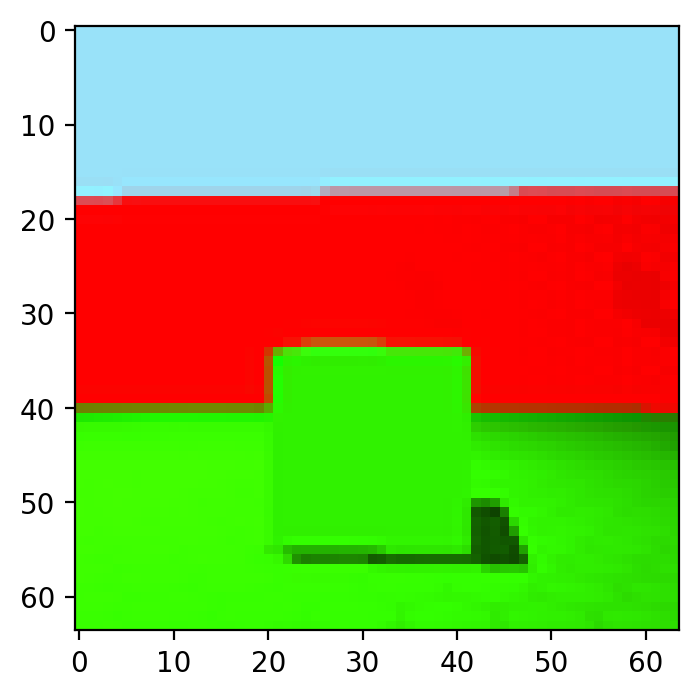

In [604]:
plt.imshow(base_set_ims[1500]/255)

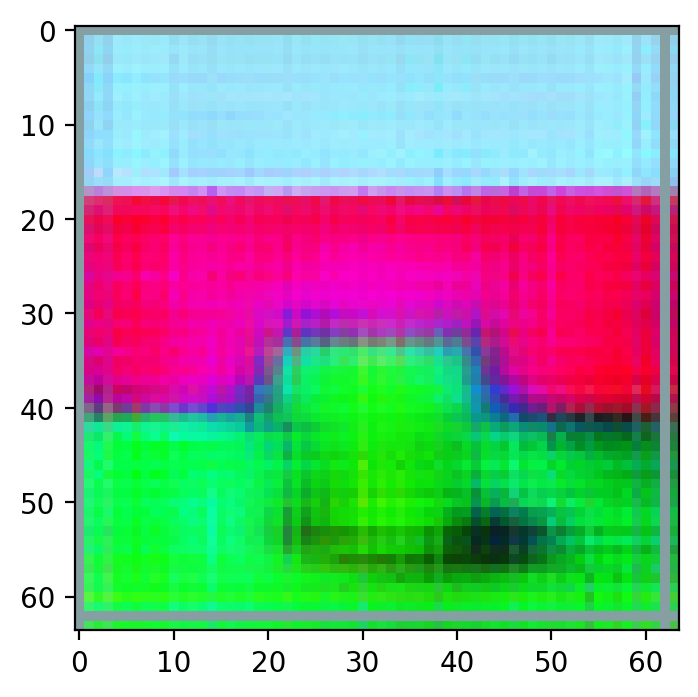

In [605]:
plt.imshow(ae(torch.from_numpy(base_set_ims[1500].transpose(2,0,1)).unsqueeze(0).float())[0].detach().squeeze(0).numpy().transpose(1,2,0))

In [606]:
np.argmax(ae(torch.from_numpy(base_set_ims[1500].transpose(2,0,1)).unsqueeze(0).float())[b1].detach().squeeze(0).numpy())

3

# Representational Similarity Analysis

Sid: If you check the results folder you will find 18 models. The way they are named is {dataset}\_{training mode}\_{network number}
Dataset refers to base, overlap_50, or overlap_20. The second dataset has 50% overlap with the base set and the second one has 20% overlap with the base set. The training mode has 3 numbers: 0 refers to a model trained only on image reconstruction loss, 1 refers to a model trained on image and label loss, and 3 refers to models trained only on label loss. All these models have predictable and interesting training trajectories that you can check on wandb. Ignore the network number for now, i.e., we can restrict our analyses to models with network number 0. So that gives us 3*3 = 9 unique models. We could do RSAs for all of these models using a validation set of images I've set up just before the main training loop.


I think your RSA code needs to be tinkered a bit because it still expects MNIST digits. You should have all the pieces in place. Could you try and run the RSA analyses on your machine/Colab pro?


## Helper functions

In [321]:
def custom_torch_RSM_fct(features):
  """
  Custom function to calculate representational similarity matrix (RSM) of a feature
  matrix using pairwise cosine similarity.

  Args:
    features: 2D torch.Tensor
      Feature matrix of size (nbr items x nbr features)

  Returns:
    rsm: 2D torch.Tensor
      Similarity matrix of size (nbr items x nbr items)
  """
  features = torch.from_numpy(features)
  num_items, num_features = features.shape

  rsm = torch.nn.functional.cosine_similarity(
      features.reshape(1, num_items, num_features),
      features.reshape(num_items, 1, num_features),
      dim=2
      )

  if not rsm.shape == (num_items, num_items):
    raise ValueError(
        f"RSM should be of shape ({num_items}, {num_items})"
        )
  return rsm

In [610]:
def wandb_rsm_init():
  wandb.init(project="ConceptualAlignmentLanguage", entity="psych-711")
  wandb.run.name = 'rsms'
  
def compute_rsms(save_dir, batch_size, latent_dims, num_classes, test_data):
  '''
  Computes RSMs of all the models
  '''
  #all_rsms = torch.rand((len(os.listdir(save_dir)), 10000 ,10000))
  all_rsms = torch.rand((len(os.listdir(save_dir)), 4000 ,4000))
  print(all_rsms.shape)
  model_names = []
  print('Computing RSMs')
  for i, model in tqdm(enumerate(os.listdir(save_dir))):
    model_names.append(model)
    autoencoder = Autoencoder(latent_dims, num_classes).to(device) # GPU
    autoencoder.eval()
    autoencoder.load_state_dict(torch.load(os.path.join(save_dir, model)))
    autoencoder.eval()
    #initialise arrays
    latent_representations = np.asarray([[0,0,0,0,0,0,0,0,0,0]])
    labels = np.asarray([0])
    for image_batch, label_batch in test_data:
        image_batch = image_batch.to(device)
        label_batch_one_hot = F.one_hot(label_batch, num_classes=num_classes)
        label_batch_one_hot = label_batch_one_hot.to(device)
        z = autoencoder.encoder.forward(image_batch, label_batch_one_hot.float()) 
        latent_representations = np.vstack((latent_representations, z.cpu().detach()))
        labels = np.concatenate((labels, label_batch.float().cpu().detach()))
    labels = labels[1:]    
    latent_representations = latent_representations[1:]
    sorted_idx = np.array([], dtype = np.int8)

    for label_class in range(num_classes):
      sorted_idx = np.concatenate((sorted_idx, np.where(labels==label_class)[0]))
    latent_representations = latent_representations[sorted_idx]
    rsm = custom_torch_RSM_fct(latent_representations)
    all_rsms[i] = rsm
    plt.imshow(rsm)
    plt.colorbar()
    wandb.log({"RSM : {}".format(model): plt})
    plt.clf()
    print('Done with RSMs')
  return all_rsms, model_names


def fill_upper_triangular(matrix):
  '''
  Fills in the upper trinagular matrix for a symmetric matrix which has
  lower traingular matrix filled iin
  '''
  items, features = matrix.shape
  assert(items==features)
  for i in range(items):
    for j in range(i+1, items):
      matrix[i][j] = matrix[j][i]
  return matrix

def log_rsm(matrix, var_name):
  plt.imshow(matrix)
  plt.colorbar()
  wandb.log({var_name: plt})
  plt.clf()
  

def compute_rsa(all_rsms, model_names):
  '''
  Computes pairwise RSA (and significance) for all the models given their rsms
  '''
  rsa_corr = torch.zeros([len(model_names), len(model_names)])
  rsa_pvalue = torch.zeros([len(model_names), len(model_names)])

  # Computes the lower triangular matrix irst 
  print('Computing RSA)')
  for i in tqdm(range(len(model_names))):
    for j in range(i +1):
      rsa_corr[i][j],rsa_pvalue[i][j]= rdm_correlation_spearman(all_rsms[i], 
                                                                all_rsms[j], 
                                                                rescale=False,
                                                                permutation=False, iter=1000)
  # Fills in the upper triangular matrix
  print('Done with RSA')
  rsa_corr = fill_upper_triangular(rsa_corr)
  rsa_pvalue = fill_upper_triangular(rsa_pvalue)
  log_rsm(rsa_corr, "RSA corr")
  log_rsm(rsa_pvalue, "RSA pvalue")
  return rsa_corr, rsa_pvalue


def main_analysis_loop(save_dir, batch_size, latent_dims, num_classes, 
                       test_data):
  '''
  Takes in all the models in a saved dir and computes pairwise rsa
  '''
  wandb_rsm_init()
  all_rsms, model_names = compute_rsms(save_dir, batch_size, latent_dims, 
                                       num_classes, test_data)
  rsa_corr, rsa_pvalue = compute_rsa(all_rsms, model_names)
  rsa_corr, rsa_pvalue = fill_upper_triangular(rsa_corr), fill_upper_triangular(rsa_pvalue)


## Run RSM analysis

In [611]:
num_classes = 4 # Number of unique class labels in the dataset
latent_dims = 10
batch_size = 1024

In [ ]:
# test_data = torch.utils.data.DataLoader( 
#       torchvision.datasets.MNIST('./data', 
#             transform=torchvision.transforms.ToTensor(),
#             download=True, train = False),
#       batch_size=batch_size,
#       shuffle=False)

### Load validation arrays
validation_ims = np.load(os.path.join(data_dir,'validation_set.npy'))
validation_labs = np.load(os.path.join(data_dir,'validation_labs.npy'))

test_data = TensorDataset(torch.tensor(validation_ims.transpose(0,3,1,2)/255).float(), torch.tensor(validation_labs).to(torch.int64))

main_analysis_loop(save_dir, batch_size, latent_dims, num_classes, 
                       test_data)

torch.Size([22, 10000, 10000])
Computing RSMs


1it [00:09,  9.97s/it]

Done with RSMs


2it [00:20, 10.19s/it]

Done with RSMs


3it [00:30, 10.28s/it]

Done with RSMs


4it [00:40, 10.24s/it]

Done with RSMs


5it [00:51, 10.20s/it]

Done with RSMs


6it [01:00, 10.11s/it]

Done with RSMs


7it [01:10, 10.07s/it]

Done with RSMs


8it [01:20,  9.99s/it]

Done with RSMs


9it [01:30,  9.97s/it]

Done with RSMs


10it [01:41, 10.11s/it]

Done with RSMs


11it [01:51, 10.06s/it]

Done with RSMs


12it [02:00, 10.00s/it]

Done with RSMs


13it [02:11, 10.05s/it]

Done with RSMs


14it [02:21, 10.04s/it]

Done with RSMs


15it [02:30,  9.97s/it]

Done with RSMs


16it [02:40,  9.97s/it]

Done with RSMs


17it [02:50,  9.93s/it]

Done with RSMs


18it [03:00,  9.89s/it]

Done with RSMs


19it [03:10,  9.87s/it]

Done with RSMs


20it [03:20, 10.00s/it]

Done with RSMs


21it [03:30,  9.98s/it]

Done with RSMs


22it [03:41, 10.06s/it]


Done with RSMs
Computing RSA)


  0%|          | 0/22 [00:00<?, ?it/s]